In [1]:
!ls /kaggle/input/richters-predictor-modeling-earthquake-damage

submission_format.csv  test_values.csv	train_labels.csv  train_values.csv


# 1. Import necessary Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import time

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
%matplotlib inline
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
sns.set_style('darkgrid')

C:\Users\Yashuv\AppData\Local\Temp\ipykernel_14240\115041817.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 2. Load Dataset

In [3]:
train_val_df = pd.read_csv('data/train_values.csv')
train_labels_df = pd.read_csv('data/train_labels.csv')

In [4]:
train_labels_df.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [5]:
# adding labels to train dataset
train_df = pd.concat([train_val_df, train_labels_df['damage_grade']], axis=1)

# shape of train dataset
train_df.shape

(260601, 40)

In [6]:
train_df.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

# 3. Explore Dataset - EDA

In [7]:
train_df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [8]:
train_df.tail()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
260600,747594,21,9,9101,3,10,7,6,n,r,n,f,q,j,d,0,1,0,0,0,0,0,0,0,0,0,v,3,0,0,0,0,0,0,0,0,0,0,0,3


In [9]:
initial_columns = train_df.columns
initial_columns 

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

## Target Variable Distribution and it's visualization

In [10]:
train_df['damage_grade'].value_counts()

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

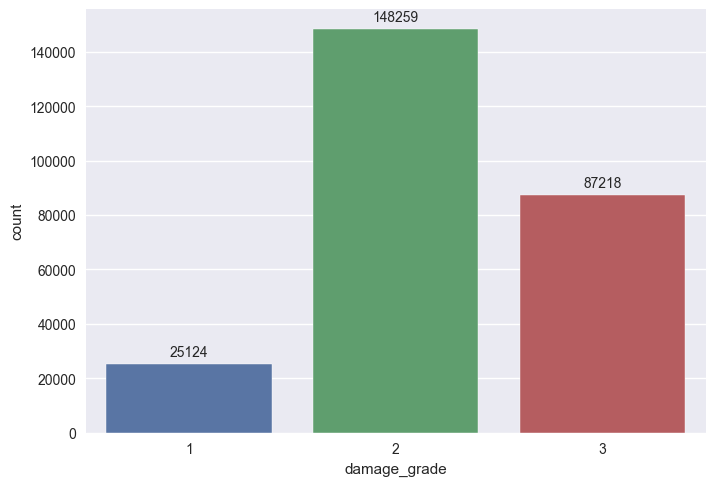

In [11]:
# countplot
ax = sns.countplot(x='damage_grade', data=train_df)

# annotate each bar with the count value
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

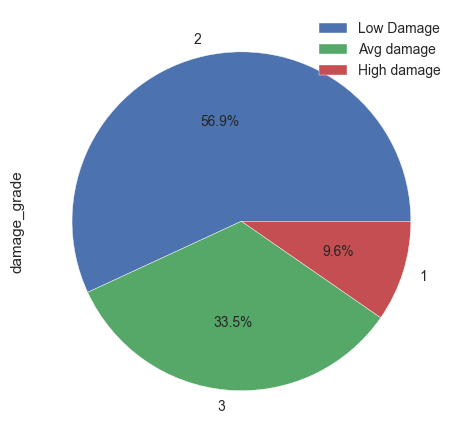

In [12]:
# pie chart
train_df['damage_grade'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.legend(["Low Damage","Avg damage","High damage"])
plt.show()

## See column names and data types

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

## Summary Statistics

In [14]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
building_id,260601.0,525675.482773,304544.999032,4.0,261190.0,525757.0,789762.0,1052934.0
geo_level_1_id,260601.0,13.900353,8.033617,0.0,7.0,12.0,21.0,30.0
geo_level_2_id,260601.0,701.074685,412.710734,0.0,350.0,702.0,1050.0,1427.0
geo_level_3_id,260601.0,6257.876148,3646.369645,0.0,3073.0,6270.0,9412.0,12567.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0
has_superstructure_adobe_mud,260601.0,0.088645,0.284231,0.0,0.0,0.0,0.0,1.0
has_superstructure_mud_mortar_stone,260601.0,0.761935,0.425900,0.0,1.0,1.0,1.0,1.0


In [15]:
# stats of object type features of train dataset
train_df.describe(include="object").T

,count,unique,top,freq
land_surface_condition,260601,3,t,216757
foundation_type,260601,5,r,219196
roof_type,260601,3,n,182842
ground_floor_type,260601,5,f,209619
other_floor_type,260601,4,q,165282
position,260601,4,s,202090
plan_configuration,260601,10,d,250072
legal_ownership_status,260601,4,v,250939


## Check for missing values

In [17]:
train_df.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

## Visualize the correlation between features

C:\Users\Yashuv\AppData\Local\Temp\ipykernel_14240\2068579447.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, cmap='inferno')


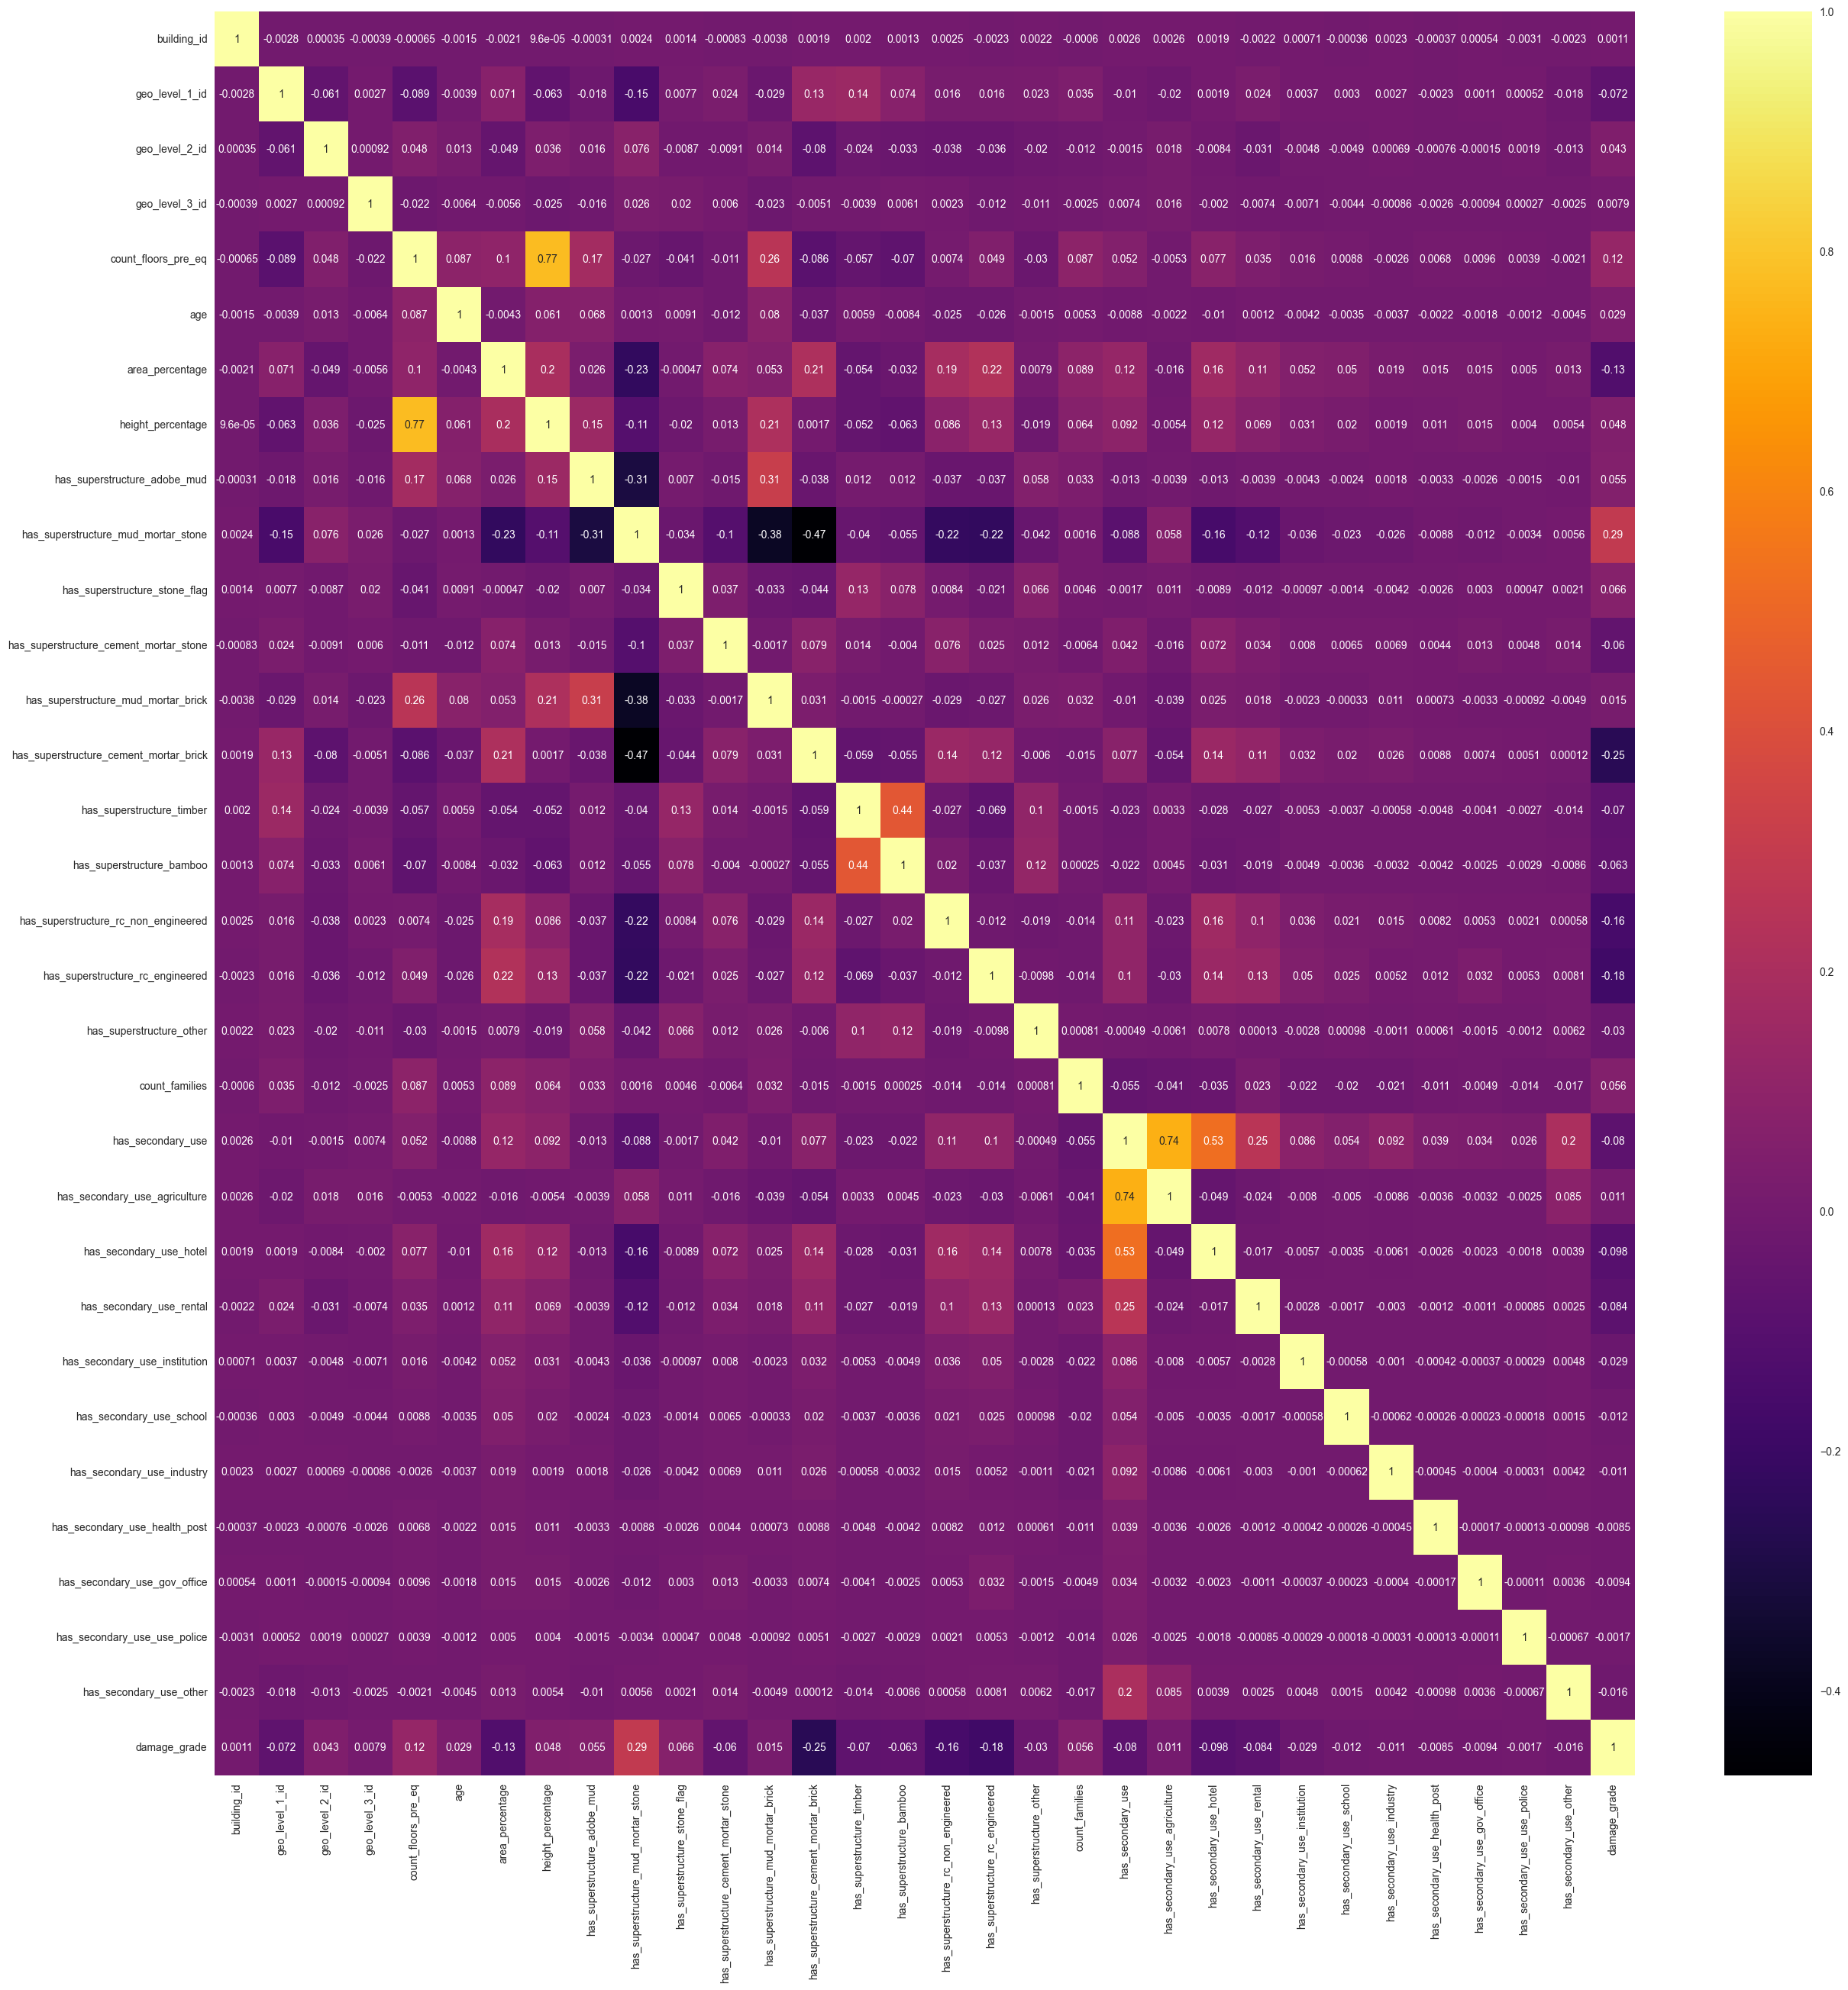

In [18]:
plt.figure(figsize=(30, 30))
sns.heatmap(train_df.corr(), annot=True, cmap='inferno')
plt.show()

# 4. Pre-processing

## Outliers in dataset

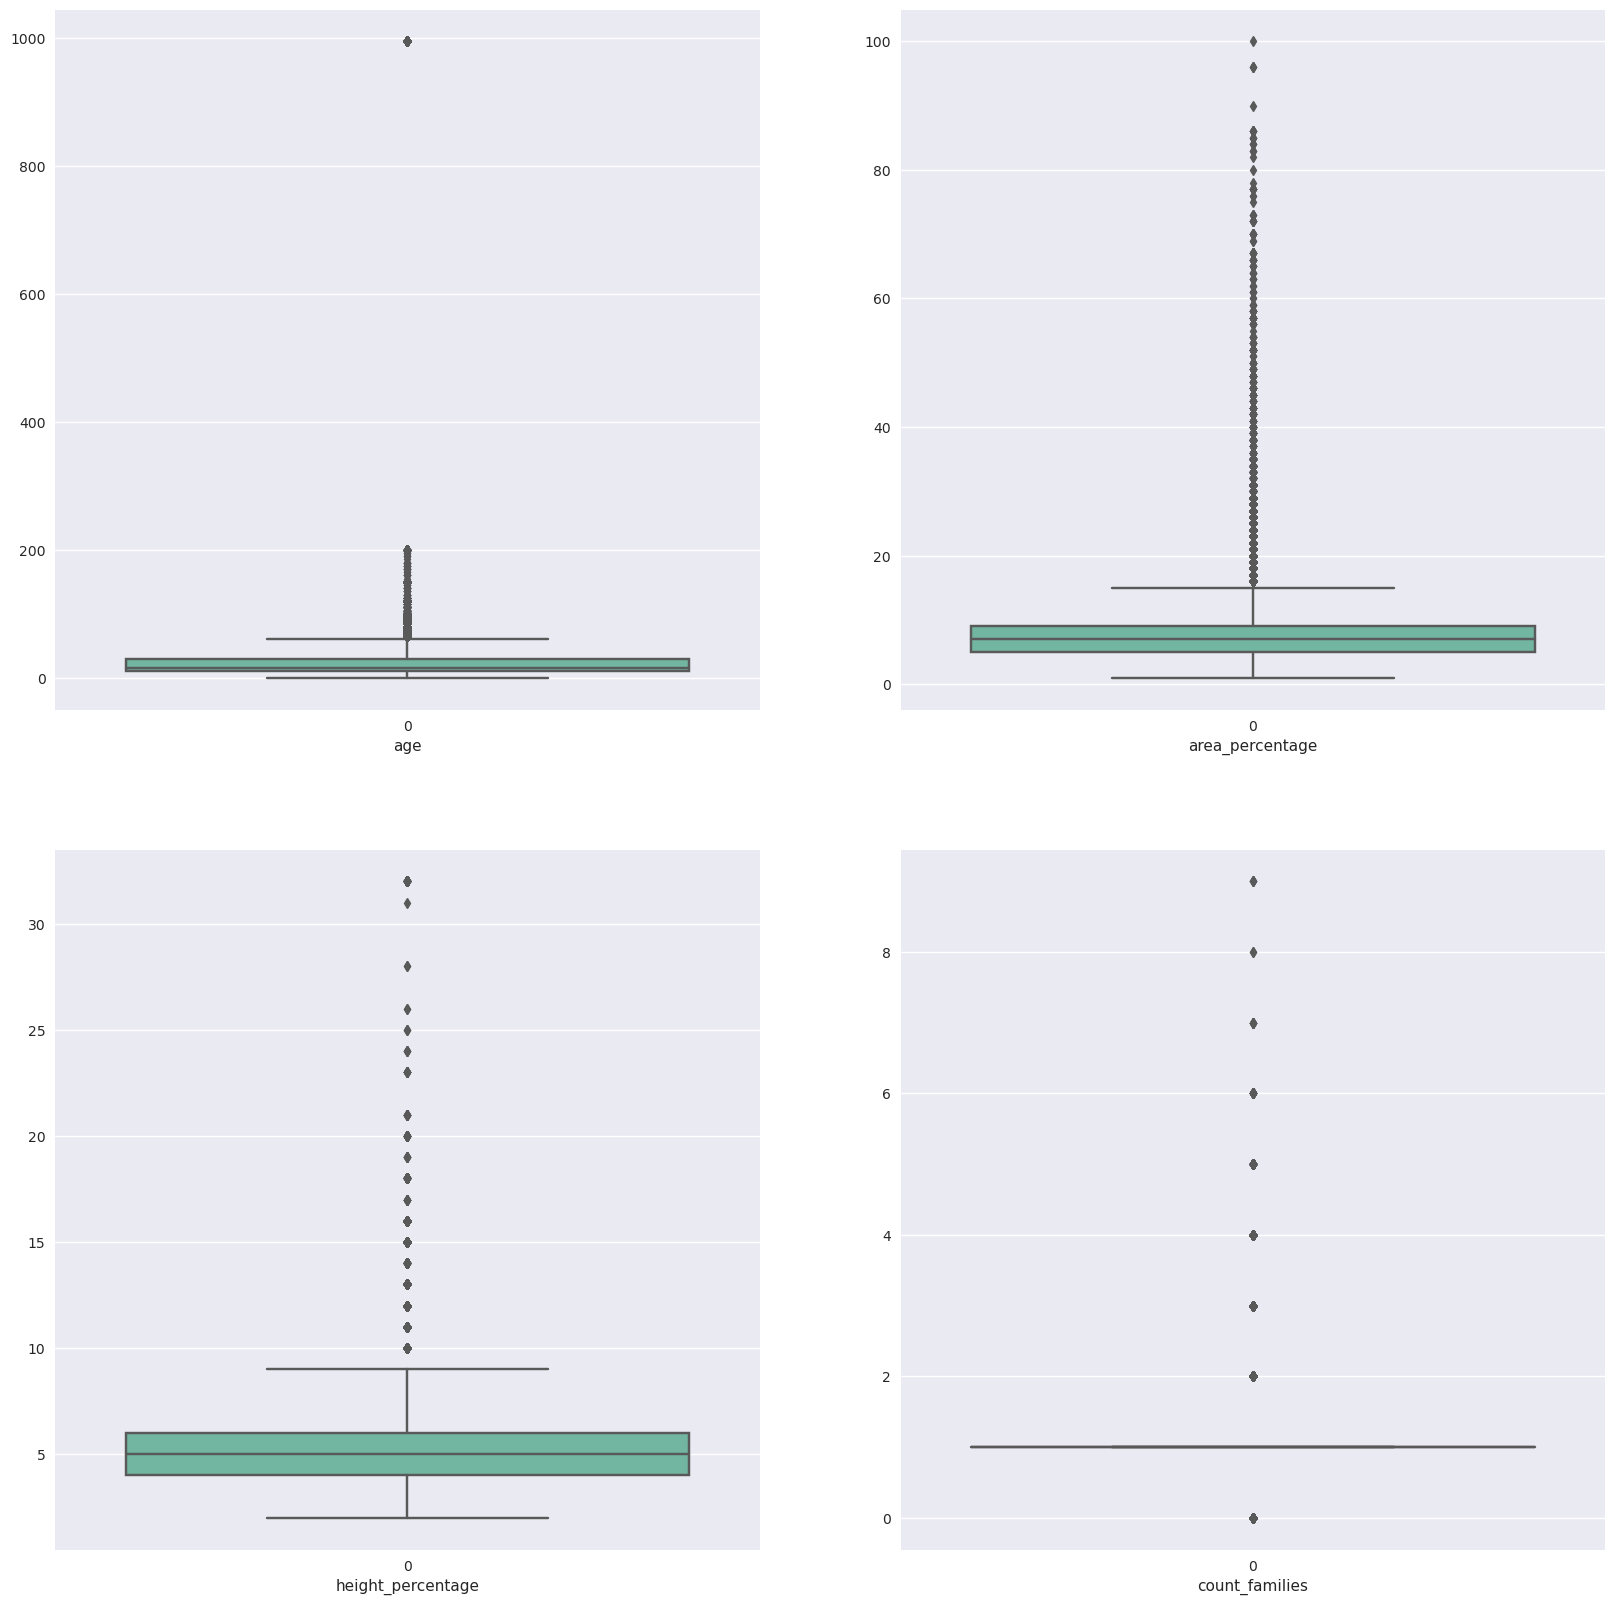

In [18]:
# potential outliers columns
boxplot_cols=["age","area_percentage","height_percentage","count_families"]

def check_outliers(columns):
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for ax, col in zip(axes.flatten(), boxplot_cols):
        sns.boxplot(train_df[col], ax=ax, palette="Set2")
        ax.set_xlabel(col)
    plt.show()

check_outliers(boxplot_cols)

In [19]:
train_df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## Remove outliers using z-score method

In [20]:
from scipy.stats import zscore

# columns to remove outliers from
cols = ["age", "area_percentage", "height_percentage", "count_families"]

# z-scores for each column
z_scores = train_df[cols].apply(zscore)

# del any rows with z-scores that exceed a threshold of 3
train_df = train_df[(z_scores.abs() < 3).all(axis=1)]

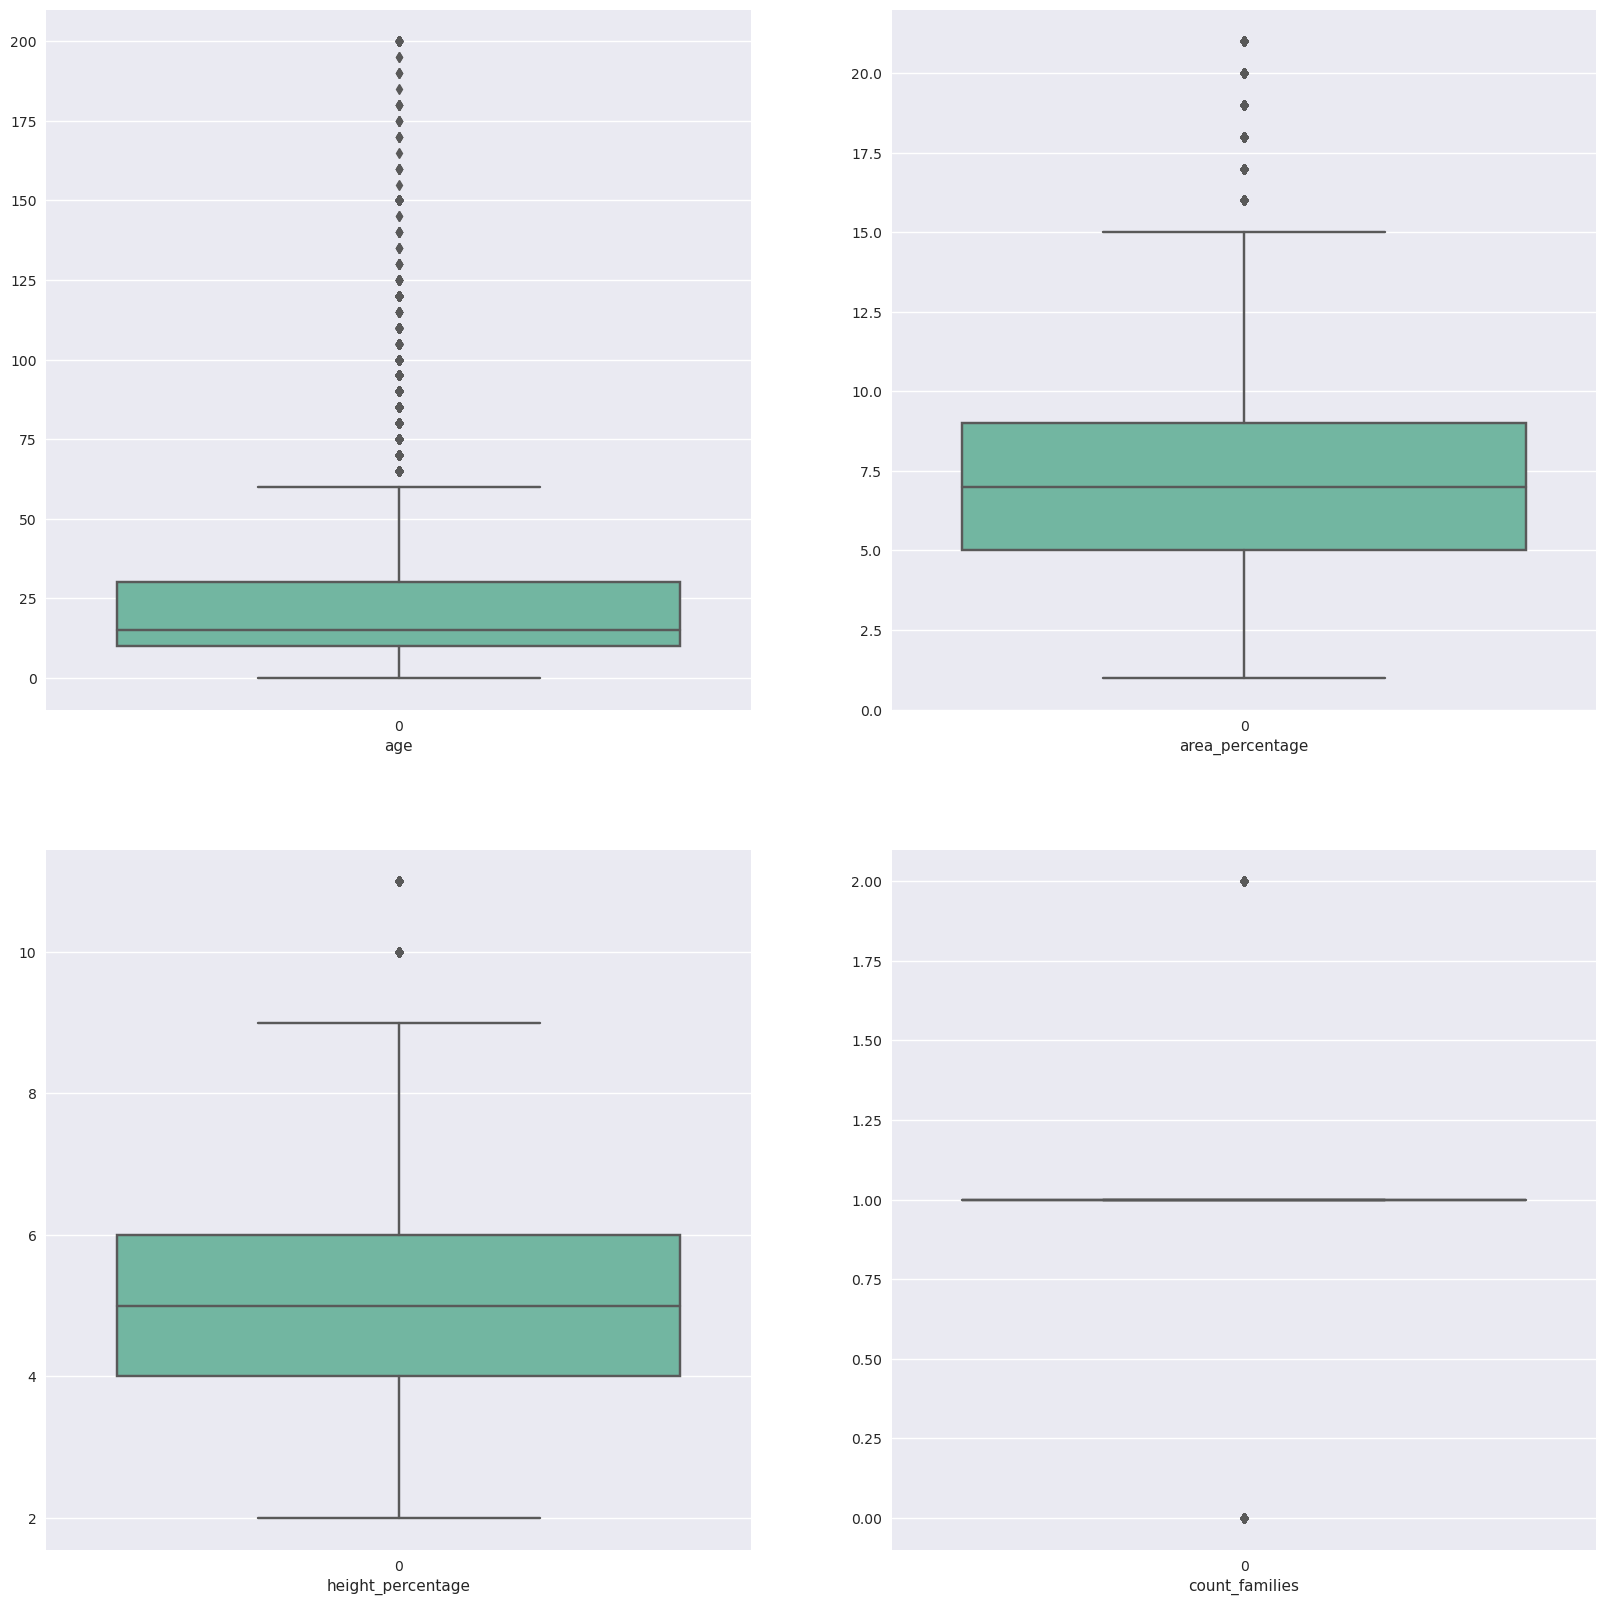

In [21]:
check_outliers(boxplot_cols)

In [22]:
#shape after removing outliers
train_df.shape

(251246, 40)

## Remove Highly Correlated Features

In [23]:
# # correlation threshold
# corr_threshold = 0.7

# # correlation matrix
# corr_matrix = train_df.corr().abs()

# # upper triangle of the correlation matrix
# upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # features with correlation > threshold
# features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]

# # drop the highly correlated features
# train_df = train_df.drop(columns=features_to_drop, axis=1)

In [24]:
# features_to_drop

# OR
# # removed columns (correlated columns)
# high_corr_features = list(set(initial_columns) - set(train_df.columns))

In [25]:
# from sklearn.preprocessing import LabelEncoder

# # create label encoder object
# le = LabelEncoder()

# # fit and transform the categorical feature
# df['size_encoded'] = le.fit_transform(df['size'])

## perform PCA 

In [26]:
# # PCA
# pca = PCA(n_components=0.95) # retain 95% of the variance in the data,
# pca.fit(train_df)

# # transform the data using the PCA model
# df_pca = pca.transform(train_df)

In [27]:
# train_df['count_floors_pre_eq']

In [28]:
train_df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## Convert categorical data to numerical data

In [19]:
X = train_df.copy()
# drop building_id and dependent variable damage_grade
X = X.drop(["damage_grade", "building_id", "has_secondary_use"], axis=1)

# dependent variable
y = train_df["damage_grade"]

# categorical variables
label_encoding_columns = ['land_surface_condition', 'foundation_type', 'roof_type','ground_floor_type', 
                          'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']

# label encoding categorical columns in train dataset 
X[label_encoding_columns] = X[label_encoding_columns].apply(lambda x: x.astype('category').cat.codes)

# same for test dataset
# test[label_encoding_columns] = test[label_encoding_columns].apply(lambda x: x.astype('category').cat.codes)


In [20]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,2,2,0,0,1,3,2,1,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,1,2,0,3,1,2,2,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,2,2,0,0,3,3,2,0,1,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0
3,22,418,10694,2,10,6,5,2,2,0,0,3,2,2,0,1,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0
4,11,131,1488,3,30,8,9,2,2,0,0,3,2,2,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0


In [31]:
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# StandardScaler object
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(X)

# Create a PCA object
pca = PCA()

# Fit the PCA object to the scaled data
pca.fit(scaled_data)

# Get the eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# Get the explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_

# Get the cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()
'''

"\nfrom sklearn.decomposition import PCA\nfrom sklearn.preprocessing import StandardScaler\n\n# Create a StandardScaler object\nscaler = StandardScaler()\n\n# Fit and transform the data\nscaled_data = scaler.fit_transform(X)\n\n# Create a PCA object\npca = PCA()\n\n# Fit the PCA object to the scaled data\npca.fit(scaled_data)\n\n# Get the eigenvalues and eigenvectors\neigenvalues = pca.explained_variance_\neigenvectors = pca.components_\n\n# Get the explained variance ratio\nexplained_var_ratio = pca.explained_variance_ratio_\n\n# Get the cumulative explained variance ratio\ncumulative_var_ratio = np.cumsum(explained_var_ratio)\n\n# Plot the cumulative explained variance ratio\nplt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio)\nplt.xlabel('Number of Principal Components')\nplt.ylabel('Cumulative Explained Variance Ratio')\nplt.show()\n"

## Choosing 30 as the value of n_components

## Perform cross-validation with different numbers of components using PCA and logistic regression:

In [32]:
# from sklearn.model_selection import cross_val_score
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LogisticRegression


# # X = train_df.drop(["damage_grade","building_id", "has_secondary_use"], axis=1)
# # y = train_df["damage_grade"]

# # Perform cross-validation with different numbers of components
# for n_components in [25, 30, 35, 37]:
#     # Create PCA object with specified number of components
#     pca = PCA(n_components=n_components)

# #     scaled_data = scaler.fit_transform(X)
    
#     # Transform the data using PCA
#     X_pca = pca.fit_transform(scaled_data)

#     # Create a logistic regression model
#     lr = LogisticRegression()

#     # Perform cross-validation and print the mean score
#     scores = cross_val_score(lr, X_pca, y, cv=5)
    
# #     # Create a random forest classifier
# #     rfc = RandomForestClassifier()

#     # Perform cross-validation and print the mean score
#     scores = cross_val_score(lr, X_pca, y, cv=5)
    
#     print("n_components: {}, mean score: {}".format(n_components, scores.mean()))

## Selecting Hyperparameter using Grid Search

In [33]:
# rf = RandomForestClassifier()
# param = {'n_estimators': [10, 150, 300],
#         'max_depth': [30, 60, 90, None]}

# gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
# gs_fit = gs.fit(X, y)
# pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

# 5. Modeling

In [25]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, RandomOverSampler

In [29]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
def performance_metric_report():
    '''
    Generate the confusion matrix and classification report
    '''
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                         index=['Actual:1','Actual:2','Actual:3'])
    # confusion matrix in heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(cr) 
    
def feature_imp(model):
    feature_names = X_train.columns

    #  feature importances
    importances = model.feature_importances_

    # (feature, importance) tuples
    feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_names, importances)]

    # sort in descending order
    sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    # feature importances display
    for feature, importance in sorted_feature_importances:
        print(f"{feature}: {importance}")

## Random Forest: 
###  Using Random Forest Classifier and the imblearn library for resampling the data to deal with skewness in multiclass classification

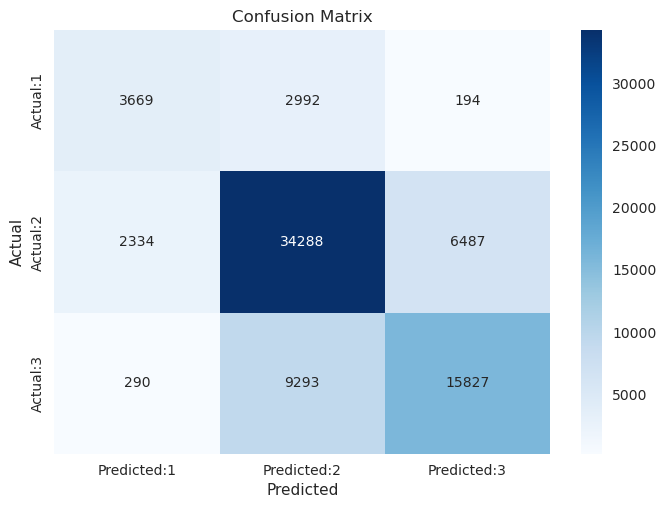

              precision    recall  f1-score   support

           1       0.58      0.54      0.56      6855
           2       0.74      0.80      0.76     43109
           3       0.70      0.62      0.66     25410

    accuracy                           0.71     75374
   macro avg       0.67      0.65      0.66     75374
weighted avg       0.71      0.71      0.71     75374

Time taken:  183.5683467388153


In [37]:
start_time = time.time()


# 1
# pca = PCA(n_components=30)

# X_pca = pca.fit_transform(X)

rfc = RandomForestClassifier(n_estimators = 500,random_state = 1, max_depth=None,n_jobs=-1)

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

rfc.fit(X_train_resampled, y_train_resampled)

y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

performance_metric_report()

end_time = time.time()
total_time = end_time - start_time
print("Time taken: ", total_time)

In [39]:
# X_train_resampled.shape # (300801, 30)
'''
              precision    recall  f1-score   support

           1       0.51      0.60      0.55      6855
           2       0.73      0.73      0.73     43109
           3       0.65      0.61      0.63     25410

    accuracy                           0.68     75374
   macro avg       0.63      0.65      0.63     75374
weighted avg       0.68      0.68      0.68     75374

'''
# feature_imp(rfc)

'\n              precision    recall  f1-score   support\n\n           1       0.51      0.60      0.55      6855\n           2       0.73      0.73      0.73     43109\n           3       0.65      0.61      0.63     25410\n\n    accuracy                           0.68     75374\n   macro avg       0.63      0.65      0.63     75374\nweighted avg       0.68      0.68      0.68     75374\n\n'

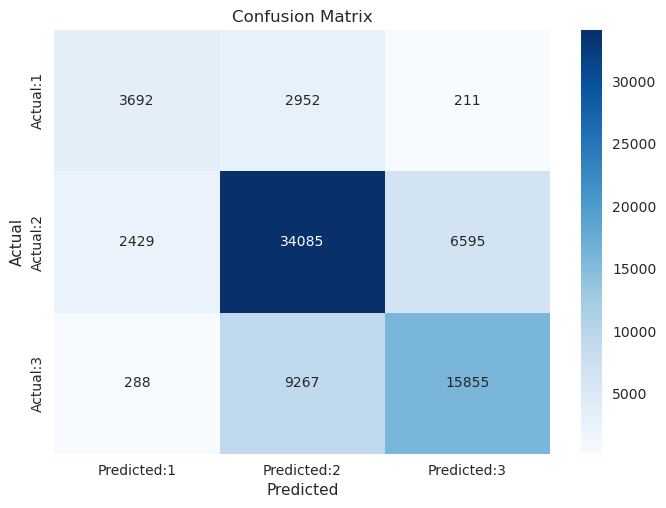

              precision    recall  f1-score   support

           1       0.58      0.54      0.56      6855
           2       0.74      0.79      0.76     43109
           3       0.70      0.62      0.66     25410

    accuracy                           0.71     75374
   macro avg       0.67      0.65      0.66     75374
weighted avg       0.71      0.71      0.71     75374

Time taken:  122.83278965950012


In [40]:
#2nd Approach

start_time = time.time()


# pca = PCA(n_components=30)
# X_train_pca = pca.fit_transform(X_train)

# X_test_pca = pca.transform(X_test)

rfc = RandomForestClassifier()
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
rfc.fit(X_resampled, y_resampled)

y_pred = rfc.predict(X_test)

performance_metric_report()

end_time = time.time()
total_time = end_time - start_time
print("Time taken: ", total_time)

In [41]:
'''
feature_imp         precision    recall  f1-score   support

           1       0.51      0.60      0.55      6855
           2       0.73      0.73      0.73     43109
           3       0.64      0.61      0.63     25410

    accuracy                           0.68     75374
   macro avg       0.63      0.65      0.63     75374
weighted avg       0.68      0.68      0.68     75374
'''
# feature_imp(rfc)

'\nfeature_imp         precision    recall  f1-score   support\n\n           1       0.51      0.60      0.55      6855\n           2       0.73      0.73      0.73     43109\n           3       0.64      0.61      0.63     25410\n\n    accuracy                           0.68     75374\n   macro avg       0.63      0.65      0.63     75374\nweighted avg       0.68      0.68      0.68     75374\n'

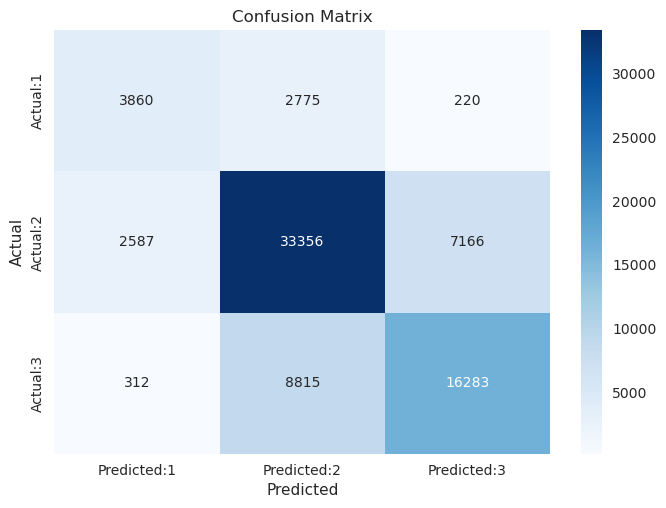

              precision    recall  f1-score   support

           1       0.57      0.56      0.57      6855
           2       0.74      0.77      0.76     43109
           3       0.69      0.64      0.66     25410

    accuracy                           0.71     75374
   macro avg       0.67      0.66      0.66     75374
weighted avg       0.71      0.71      0.71     75374

Time taken:  69.46527791023254


In [42]:
# 3rd Approach

start_time = time.time()

# pca = PCA(n_components=30)
# X_train_pca = pca.fit_transform(X_train)

# X_test_pca = pca.transform(X_test)

# oversample the minority classes
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train_resampled, y_train_resampled)

y_pred = rfc.predict(X_test)

performance_metric_report()

end_time = time.time()
total_time = end_time - start_time
print("Time taken: ", total_time)

In [43]:
# feature_imp(rfc)

## XGBClassifier:
###  Using XGBClassifier and the imblearn library for resampling the data to deal with skewness in multiclass classification

Accuracy of XGBClassier:  0.7169713694377372


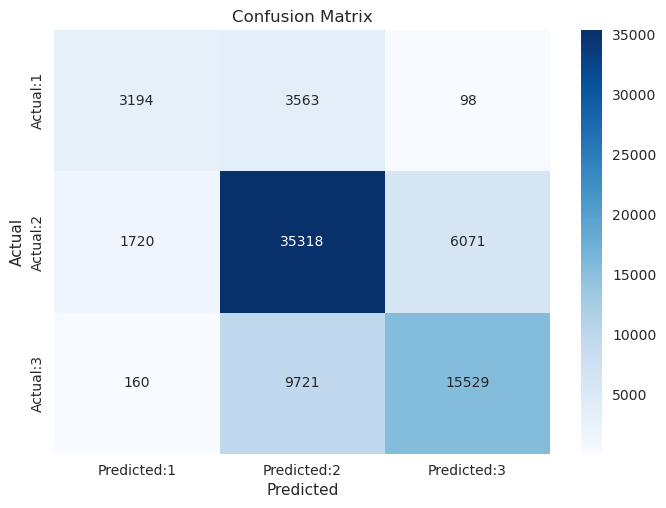

              precision    recall  f1-score   support

           0       0.63      0.47      0.54      6855
           1       0.73      0.82      0.77     43109
           2       0.72      0.61      0.66     25410

    accuracy                           0.72     75374
   macro avg       0.69      0.63      0.65     75374
weighted avg       0.71      0.72      0.71     75374

Time taken:  115.5090684890747


In [44]:
# 4th approach
start_time = time.time()

# pca = PCA(n_components=30)
# X_train_pca = pca.fit_transform(X_train)

y_train = y_train - 1
y_test = y_test - 1

xgb = XGBClassifier()

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

xgb.fit(X_resampled, y_resampled)

y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of XGBClassier: ", accuracy)

performance_metric_report()

end_time = time.time()
total_time = end_time - start_time
print("Time taken: ", total_time)

In [45]:
# feature_imp(XGB)

Accuracy of XGBClassier:  0.6683073738955078


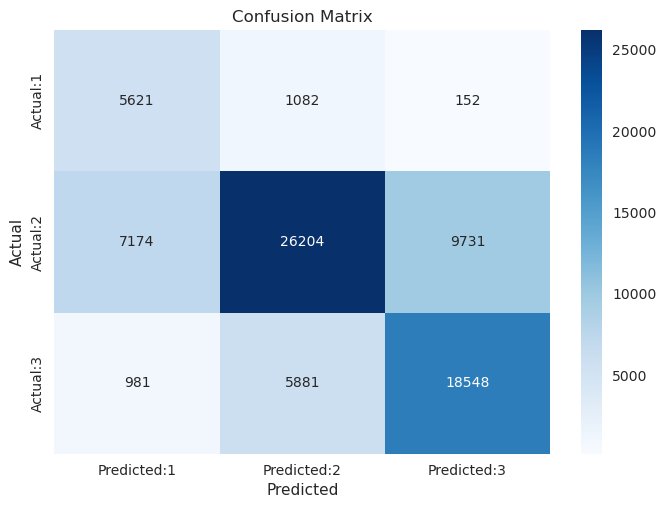

              precision    recall  f1-score   support

           0       0.41      0.82      0.54      6855
           1       0.79      0.61      0.69     43109
           2       0.65      0.73      0.69     25410

    accuracy                           0.67     75374
   macro avg       0.62      0.72      0.64     75374
weighted avg       0.71      0.67      0.67     75374

Time taken:  68.40180850028992


In [46]:
# 5th approach
start_time = time.time()

# the XGBclassifier expects the classes to be 0, 1, or 2, but the classes in y are 1, 2, and 3.
y_train = y_train 
y_test = y_test 

xgb = XGBClassifier()

# RandomOverSampler to oversample the minority classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# fit the model 
xgb.fit(X_resampled, y_resampled)

# evaluate 
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of XGBClassier: ", accuracy)

performance_metric_report()

end_time = time.time()
total_time = end_time - start_time
print("Time taken: ", total_time)

In [47]:
# feature_imp(XGB)

In [48]:
# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1.0],
#     'colsample_bytree': [0.5, 0.7, 1.0],
# }

# # Create an XGBClassifier object
# xgb = XGBClassifier(random_state=42)

# # Perform grid search cross-validation to find the best hyperparameters
# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1
# )

# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print('Best parameters:', grid_search.best_params_)
# print('Best score:', grid_search.best_score_)


In [49]:
# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1.0],
#     'colsample_bytree': [0.5, 0.7, 1.0],
# }

# # XGBClassifier object
# xgb = XGBClassifier(random_state=42)

# # do randomized search cross-validation to find the best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_distributions=param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1,
#     n_iter=20
# )

# random_search.fit(X_train, y_train)

# # get best parameters and best score
# print('Best parameters:', random_search.best_params_)
# print('Best score:', random_search.best_score_)

### Fitting Using Different Classifiers to access performance

In [13]:
# fitting methods to try
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier()]

def model_and_test(x, y, classifiers):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)
    for model in classifiers:
        this_model = model.__class__.__name__ #get the name of the classifier
        if this_model == 'XGBClassifier':
            model.fit(x_train, y_train-1)
            y_pred = model.predict(x_test)

            print(f'{this_model} f1 score:')
            score = f1_score(y_test-1, y_pred,average='micro')
            print(f'{score:.4f}')
            print('\n')
        else:
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)

            print(f'{this_model} f1 score:')
            score = f1_score(y_test, y_pred,average='micro')
            print(f'{score:.4f}')
            print('\n')

In [14]:
model_and_test(X, y, classifiers)

KNeighborsClassifier f1 score:
0.7043


DecisionTreeClassifier f1 score:
0.6586


RandomForestClassifier f1 score:
0.7236


AdaBoostClassifier f1 score:
0.6451


GradientBoostingClassifier f1 score:
0.6811


XGBClassifier f1 score:
0.7271




In [23]:
# since XGBClassifier expects class to be 0, 1, 2 but we have 1,2,3
y_train = y_train - 1
y_test = y_test - 1

# calc. class weights for imbalanced classes
weights = (y == 0).sum() / (1.0 * (y == 1).sum())

# Create an XGBoost Classifier with class weights and default hyperparameters
xgb = XGBClassifier(scale_pos_weight=weights)

# fit
xgb.fit(X_train, y_train)

# Evaluate
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of XGBClassifier: ", accuracy)

score = f1_score(y_test, y_pred,average='micro')
print(f'{score:.4f}')
print('\n')

[23:14:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Accuracy of XGBClassifier:  0.7269413284557629
0.7269




In [30]:
#  XGBoost Classifier with class weights
xgb = RandomForestClassifier(class_weight={1: 6, 2: 1, 3:2})

# Fit
xgb.fit(X_train, y_train)

# Evaluate 
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of RandomForestClassifier: ", accuracy)

score = f1_score(y_test, y_pred,average='micro')
print(f'{score:.4f}')
print('\n')

Accuracy of XGBClassifier:  0.7137028178201865
0.7137


